# Conditional Variational Autoencoders

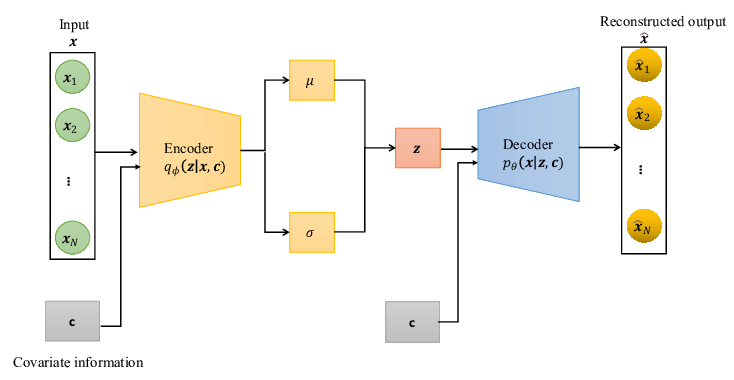

In [ ]:
import tensorflow as tf
import optuna
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from scipy.stats import spearmanr, pearsonr, chi2_contingency, normaltest, mstats
from sklearn.metrics import mutual_info_score
import warnings
warnings.filterwarnings("ignore")

from utils.utils import plot_probobability_distributions

## The Data

In [2]:
cluster_name = "influencers"

In [22]:
users_df = pd.read_csv(f"temp/{cluster_name}_atributes.csv")

tweets_df = df = pd.read_csv(f"temp/{cluster_name}_tweets_probabilities.csv")
tweets_n_columns = len(tweets_df.columns.to_list())-2

merged_df = tweets_df.merge(users_df, on="user_id", suffixes=['_tweet', '_user'])
merged_df.drop(['user_id', 'tweet_tweet'], axis=1, inplace=True)
display(merged_df)

log_merged_df = np.log1p(merged_df + 1e-10)
tweet_data = log_merged_df.iloc[:, :tweets_n_columns].to_numpy(dtype=np.float32)
user_data = log_merged_df.iloc[:, tweets_n_columns:].to_numpy(dtype=np.float32)

tweet_scaler = MinMaxScaler()
tweet_data = tweet_scaler.fit_transform(tweet_data)
user_data = MinMaxScaler().fit_transform(user_data)

# Get the input dimensions
tweet_dim = tweet_data.shape[1]
user_dim = user_data.shape[1]

# Create a dataset
dataset = tf.data.Dataset.from_tensor_slices(((tweet_data, user_data), tweet_data))
dataset = dataset.shuffle(buffer_size=100)

train_samples = int(0.8 * len(tweet_data))
train_dataset = dataset.take(train_samples).batch(32)
test_dataset = dataset.skip(train_samples).batch(32)

print(len(train_dataset))
print(len(test_dataset))

topic_probs_arts_&_culture_tweet  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   
...                                 ...   
10801                               0.0   
10802                               0.0   
10803                               0.0   
10804                               0.0   
10805                               0.0   

       topic_probs_business_&_entrepreneurs_tweet  \
0                                            0.84   
1                                            0.00   
2                                            0.00   
3                                            0.53   
4                                            0.00   
...                                           ...   
10801                                        0.00   
10802                                        0.00   
10803                                        0.00   
10804                                        0.00   
10805                                        0.00   

       topic_probs_celebrity_&_pop_culture_tweet  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   
...                                          ...   
10801                                        0.0   
10802                                        0.0   
10803                                        0.0   
10804                                        0.0   
10805                                        0.0   

       topic_probs_diaries_&_daily_life_tweet  topic_probs_family_tweet  \
0                                        0.00                       0.0   
1                                        0.00                       0.0   
2                                        0.00                       0.0   
3                                        0.00                       0.0   
4                                        0.00                       0.0   
...                                       ...                       ...   
10801                                    0.88                       0.0   
10802                                    0.00                       0.0   
10803                                    0.00                       0.0   
10804                                    0.00                       0.0   
10805                                    0.00                       0.0   

       topic_probs_fashion_&_style_tweet  topic_probs_film_tv_&_video_tweet  \
0                                    0.0                               0.00   
1                                    0.0                               0.00   
2                                    0.0                               0.00   
3                                    0.0                               0.00   
4                                    0.0                               0.00   
...                                  ...                                ...   
10801                                0.0                               0.00   
10802                                0.0                               0.94   
10803                                0.0                               0.96   
10804                                0.0                               0.00   
10805                                0.0                               0.00   

       topic_probs_fitness_&_health_tweet  topic_probs_food_&_dining_tweet  \
0                                     0.0                              0.0   
1                                     0.0                              0.0   
2                                     0.0                              0.0   
3                                     0.0                         

271
68


## The Model

In [4]:
class CVAE(tf.keras.Model):
    def __init__(self, tweet_dim, user_dim, latent_dim, reconstruction_param, encoder_units, decoder_units, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.tweet_dim = tweet_dim
        self.user_dim = user_dim
        self.latent_dim = latent_dim
        self.reconstruction_param = reconstruction_param
        
        self.encoder = self.build_encoder(tweet_dim, user_dim, latent_dim, encoder_units)
        self.decoder = self.build_decoder(tweet_dim, user_dim, latent_dim, decoder_units)

    def build_encoder(self, tweet_dim, user_dim, latent_dim, units):
        tweet_inputs = tf.keras.Input(shape=(tweet_dim,), name="tweet_inputs")
        user_inputs = tf.keras.Input(shape=(user_dim,), name="user_inputs")
        x = layers.Concatenate()([tweet_inputs, user_inputs])
        x = layers.Dense(units, activation='relu', kernel_initializer='he_normal')(x)
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dense(units, activation='relu')(x)
        z_mean = layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
        return tf.keras.Model([tweet_inputs, user_inputs], [z_mean, z_log_var], name="encoder")
    
    def build_decoder(self, tweet_dim, user_dim, latent_dim, units):
        latent_inputs = tf.keras.Input(shape=(latent_dim,), name="latent_inputs")
        user_inputs = tf.keras.Input(shape=(user_dim,), name="user_inputs")
        x = layers.Concatenate()([latent_inputs, user_inputs])
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dense(units, activation='relu')(x)
        decoder_outputs = layers.Dense(tweet_dim, activation='sigmoid')(x)
        return tf.keras.Model([latent_inputs, user_inputs], decoder_outputs, name="decoder")

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train_step(self, data):
        (tweet_data, user_data), targets = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder([tweet_data, user_data])
            z = self.sampling((z_mean, z_log_var))
            reconstruction = self.decoder([z, user_data])
            
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(targets, reconstruction)
            )
            reconstruction_loss *= targets.shape[1]

            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = -tf.reduce_mean(kl_loss)

            total_loss = (
                self.reconstruction_param * reconstruction_loss +
                (1 - self.reconstruction_param) * kl_loss
            )

        # Apply gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    def reconstruct_tweets(self, dataset):
        reconstructed_batches = []
        for (tweet_data, user_data), _ in dataset:
            z_mean, z_log_var = self.encoder([tweet_data, user_data])
            print(z_mean)
            z = self.sampling((z_mean, z_log_var))
            reconstruction = self.decoder([z, user_data])
            reconstructed_batches.append(reconstruction.numpy())

        return np.concatenate(reconstructed_batches, axis=0)


    def generate_tweets(self, user_vector, num_samples):
        z = tf.keras.backend.random_normal(shape=(num_samples, self.latent_dim))
        generated_tweets = self.decoder([z, user_vector])
        return generated_tweets

### Training the model

#### Set global parameters

In [5]:
reconstruction_param = 0.7

#### Hyperparameter tunning with Optuna

In [ ]:
%%timeit
def objective(trial, train_dataset):
    # Hyperparameter search space
    hyperparameters = {
        'latent_dim': trial.suggest_int("latent_dim", 5, 10),
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
        'encoder_units': trial.suggest_categorical("encoder_units", [32, 64, 128, 256, 512]),
    }
    
    # Instantiate the model with sampled hyperparameters
    model = CVAE(
        tweet_dim=tweet_dim,
        user_dim=user_dim,
        latent_dim=hyperparameters['latent_dim'],
        reconstruction_param=reconstruction_param,
        encoder_units=hyperparameters['encoder_units'],
        decoder_units=hyperparameters['encoder_units']  # Symmetrical
    )
    
    model.compile(optimizer=optimizers.Adam(learning_rate=hyperparameters["learning_rate"]))
    
    history = model.fit(
        train_dataset,
        epochs=500,
        batch_size=hyperparameters['batch_size'],
        verbose=0
    )
    
    # Function to evaluate the loss curve
    def evaluate_loss_curve(loss_curve):
        smoothness_penalty = np.sum(np.abs(np.diff(loss_curve)))  # Penalize abrupt changes
        final_loss = loss_curve[-1]  # Final loss
        mean_loss = np.mean(loss_curve)  # Mean loss across all epochs
        score = final_loss + 0.05 * smoothness_penalty
        return score

    # Get validation loss for evaluation
    score = evaluate_loss_curve(history.history['loss'])
    
    plt.plot(history.history['loss'],'b', label="Total Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Losses Over Epochs")
    plt.show()
    
    return score

# Run the Optuna study with pre-split data
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train_dataset), n_trials=30)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

In [6]:
#best_hyperparams = study.best_params
best_hyperparams = {'latent_dim': 10, 'learning_rate': 2.7949319576483928e-05, 'batch_size': 256, 'encoder_units': 512}
model = CVAE(
    tweet_dim=tweet_dim,
    user_dim=user_dim,
    latent_dim=best_hyperparams['latent_dim'],
    reconstruction_param=reconstruction_param,
    encoder_units=best_hyperparams['encoder_units'],
    decoder_units=best_hyperparams['encoder_units']
)

model.compile(optimizer=optimizers.Adam(learning_rate=best_hyperparams["learning_rate"]))

history = model.fit(
    train_dataset,
    epochs=200,
    batch_size=best_hyperparams['batch_size'],
    verbose=0
)

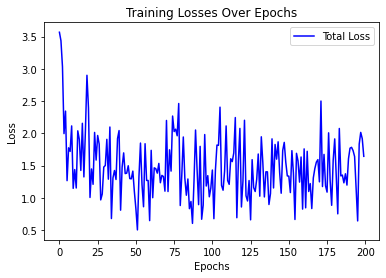

In [7]:
# Plot the losses after training
plt.plot(history.history['loss'],'b', label="Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses Over Epochs")
plt.show()

### Validate Reconstruction

In [11]:
def reconstruct_tweets(model, dataset):
    reconstructed_batches = []
    original_batches = []
    user_batches = []
    for (tweet_data, user_data), targets in dataset:
        z_mean, z_log_var = model.encoder([tweet_data, user_data])
        z = model.sampling((z_mean, z_log_var))
        reconstruction = model.decoder([z, user_data])
        reconstructed_batches.append(reconstruction.numpy())
        original_batches.append(targets.numpy())
        user_batches.append(user_data.numpy())
    return np.concatenate(original_batches, axis=0), np.concatenate(reconstructed_batches, axis=0), np.concatenate(user_batches, axis=0)

original_test_tweets, reconstruction_test_tweets, users_test_data = reconstruct_tweets(model, test_dataset)

2024-12-03 21:22:24.407933: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
print(f"Original: {np.round(original_test_tweets[:3],2)}")
print(f"Reconstructed: {np.round(reconstruction_test_tweets[:3],2)}")

Original: [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.9  0.   0.   0.   0.   0.99]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.93 0.
  0.   0.   0.49 0.   0.   0.   0.97 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.88 0.   0.   0.   0.94 0.  ]]
Reconstructed: [[0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.04 0.   0.
  0.   0.   0.96 0.   0.   0.   0.02 0.95]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.89 0.
  0.   0.   0.72 0.   0.   0.   0.93 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.99 0.   0.   0.01 0.91 0.  ]]


### Generate New Tweets (Single User)

User Statistics: 
 [0.38976002 0.00452637 0.05103315 0.02266595 0.0019727  0.7113316 ]
User Preferences: 
 [0.00452637 0.05979756 0.10924438 0.31398988 0.08518823 0.05103315
 0.04517196 0.0722087  0.03519782 0.02447544 0.02266595 0.04716843
 0.11377005 0.18394049 0.13648719 0.0019727  0.71327585 0.04550199
 0.04718173 0.04499317 0.7113316  0.4294977 ]


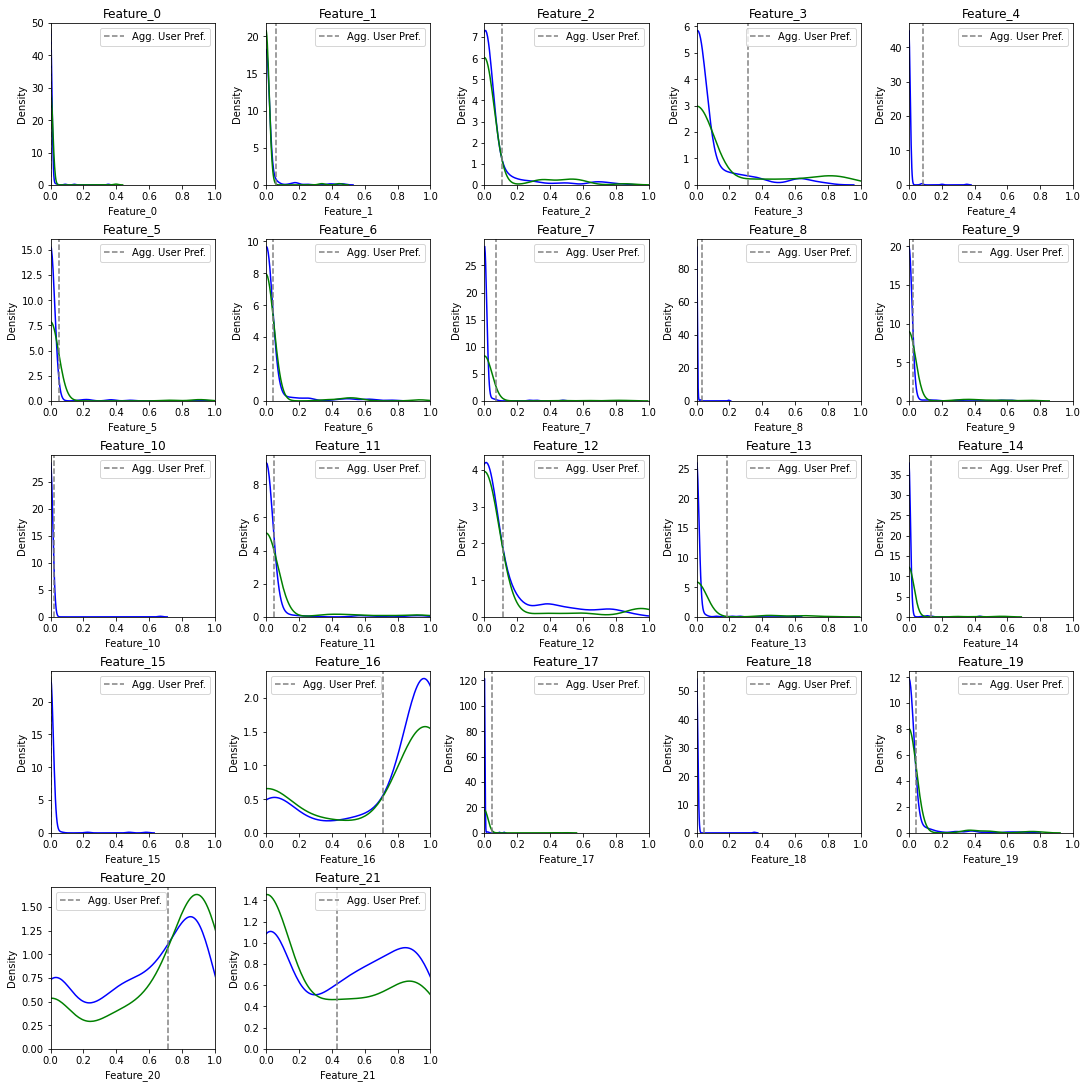

In [18]:
def generate_tweets(model, user_vector, num_samples):
    # Ensure user_vector has a batch dimension
    user_vector = tf.expand_dims(user_vector, axis=0)
    # Repeat for num_samples: (1, 27) -> (num_samples, 27)
    user_vector = tf.repeat(user_vector, num_samples, axis=0)
    
    z = tf.keras.backend.random_normal(shape=(num_samples, model.latent_dim))
    generated_tweets = model.decoder([z, user_vector])
    return generated_tweets.numpy()

validate_user = users_test_data[1]
matching_indices = np.where((users_test_data == validate_user).all(axis=1))[0]

print('User Statistics: \n', validate_user[::5])
print('User Preferences: \n', validate_user[5::])
synthetic_tweets = generate_tweets(model, validate_user, num_samples=int(len(matching_indices)*2))


def plot_distributions(user_prefs, generated_tweets, original_tweets):
    # Prepare the DataFrame
    columns = [f"Feature_{i}" for i in range(len(user_prefs))]
    user_df = pd.DataFrame([user_prefs], columns=columns)
    generated_tweets_df = pd.DataFrame(generated_tweets, columns=columns)
    original_tweets_df = pd.DataFrame(original_tweets, columns=columns)

    num_cols = 5
    num_rows = (len(columns) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    axes = axes.flatten()
    
    for i, col in enumerate(generated_tweets_df.columns):
        sns.kdeplot(generated_tweets_df[col], ax=axes[i], color='blue')
        sns.kdeplot(original_tweets_df[col], ax=axes[i], color='green')
        axes[i].axvline(x=user_df[col].iloc[0], color='grey', linestyle='--', label="Agg. User Pref.")
        axes[i].set_title(f"{col}")
        axes[i].set_xlim(0, 1)
        axes[i].legend()

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.show()
        
plot_distributions(validate_user[5::], synthetic_tweets, original_test_tweets[matching_indices])

### Generate Dataset of tweets (All dataset)

array([[2.03737430e-02, 9.38487915e-07, 1.28343294e-03, ...,
        4.25230106e-15, 3.51599488e-06, 9.86927629e-01],
       [2.19896540e-01, 2.14090051e-06, 2.18761805e-03, ...,
        2.01979660e-08, 3.20914118e-09, 9.98845458e-01],
       [2.99021714e-08, 7.31214359e-02, 4.60036498e-09, ...,
        1.09187029e-04, 7.70385889e-03, 9.08122957e-01],
       ...,
       [2.81509710e-03, 3.85713816e-01, 4.97727979e-06, ...,
        7.35318428e-09, 1.03873096e-03, 9.47827935e-01],
       [1.06074785e-05, 2.81201243e-01, 1.38709183e-05, ...,
        6.18568845e-02, 8.22222590e-01, 2.37497501e-02],
       [2.24181965e-10, 6.62429978e-09, 1.73443966e-02, ...,
        6.18336685e-07, 6.32929206e-01, 4.99322593e-01]], dtype=float32)

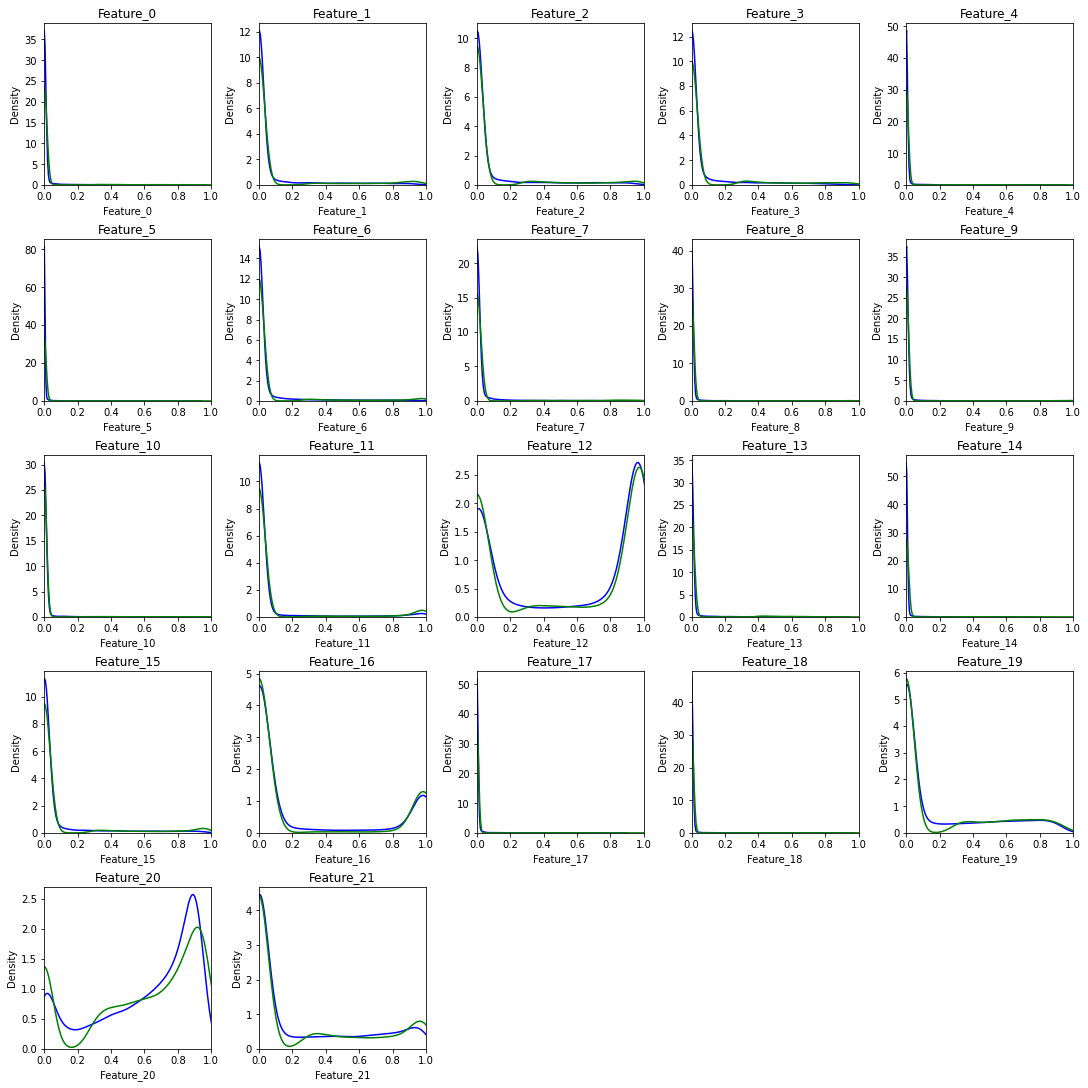

In [20]:
## You should Do it with the test data.
def generate_tweets_dataset(model, user_data):
    user_data = tf.convert_to_tensor(user_data)
    z = tf.keras.backend.random_normal(shape=(len(user_data), model.latent_dim))
    generated_tweets_dataset = model.decoder([z, user_data])
    return generated_tweets_dataset.numpy()

synthetic_tweets_dataset = generate_tweets_dataset(model, user_data)
display(synthetic_tweets_dataset)

def plot_distributions(generated_tweets, original_tweets):
    # Prepare the DataFrame
    columns = [f"Feature_{i}" for i in range(generated_tweets.shape[1])]
    generated_tweets_df = pd.DataFrame(generated_tweets, columns=columns)
    original_tweets_df = pd.DataFrame(original_tweets, columns=columns)

    num_cols = 5
    num_rows = (len(columns) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), constrained_layout=True)
    axes = axes.flatten()
    
    for i, col in enumerate(generated_tweets_df.columns):
        sns.kdeplot(generated_tweets_df[col], ax=axes[i], color='blue')
        sns.kdeplot(original_tweets_df[col], ax=axes[i], color='green')
        axes[i].set_title(f"{col}")
        axes[i].set_xlim(0,1)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.show()
        
plot_distributions(synthetic_tweets_dataset, tweet_data)